# Offline and Online UAV-enabled Data Collection in Time-constrained IoT Networks

### Import libraries


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.cluster import KMeans
import pickle
import seaborn as sns
import math
from copy import deepcopy
import copy
from scipy.stats import poisson
import random 
import statistics
from timeit import default_timer as timer
import warnings
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import time, sys
from IPython.display import clear_output
from sklearn.metrics.pairwise import paired_distances
from scipy.stats import shapiro
import csv
from scipy.spatial import distance
import time
import gym
from gym import spaces
import pandas as pd
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.cluster import KMeans
from copy import deepcopy
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as TT
import os
import warnings
from itertools import count
from PIL import Image
import ast 
import plottools

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from __future__ import print_function
!pip install ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [3]:
#colors_list= ['royalblue','gray','navy','limegreen','turquoise','lightcoral','brown','darkorange','peru','yellow','palegreen','skyblue','cyan','slateblue','blue','violet','orchid','olive','red','green']
colors = mpl.colors.ListedColormap(['royalblue','gray','navy','limegreen','turquoise','lightcoral','brown','darkorange','peru','yellow','palegreen','skyblue','cyan','slateblue','blue','violet','orchid','olive','red','green'])

# IoT sensors clustering

In [4]:
N = 2000
dth = 600
Max_it = 100
SNperCluster = 120
geo_area = 5000

### 2000 SNs uniformly distributed

In [5]:
# Create data
x = np.random.uniform(0,geo_area,N)
y = np.random.uniform(0,geo_area,N)
X = np.array(list(zip(x, y)))
area = np.pi*3

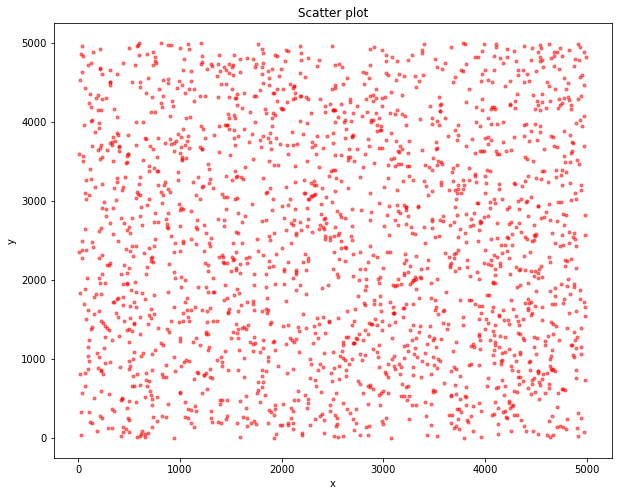

In [6]:
# Plot
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], s=area, alpha=0.5 ,c='r')
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [7]:
# Euclidean Distance Caculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [8]:
def dist2DPaired(A, B):
    return np.mean(paired_distances(A, B,metric='euclidean'))

### Kmeans

In [74]:
for j in range(N//SNperCluster+1, Max_it):
    kmeans_init = KMeans(n_clusters=j, max_iter=100)
    kmeans_init.fit(X)
    total=0
    for i in range(len(X)):
        distance = dist(X[i], kmeans_init.cluster_centers_[kmeans_init.labels_[i]],0)
        if (kmeans_init.labels_==kmeans_init.labels_[i]).sum()>SNperCluster or  distance>dth:
            break
        else:
            total+=1
    if (total==len(X)):
        number_Cluster_Kmeans_init=j
        break
print("Number of clusters are:",number_Cluster_Kmeans_init)

Number of clusters are: 41


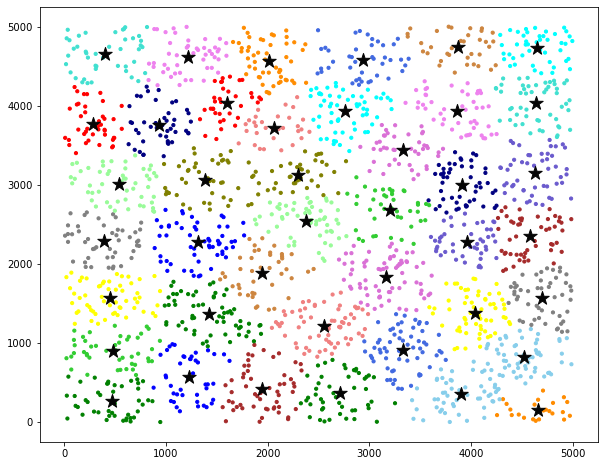

In [75]:
y_kmeans = kmeans_init.predict(X)
fig= plt.figure(figsize=(10,8))
plt.scatter(X[:, 0],X[:, 1], s=10,c=y_kmeans,cmap=colors)
plt.scatter(kmeans_init.cluster_centers_[:, 0], kmeans_init.cluster_centers_[:, 1], marker='*', s=200, c='#050505',label='CH')

### Hierarchical Agglomerative Clustering (HAC) 

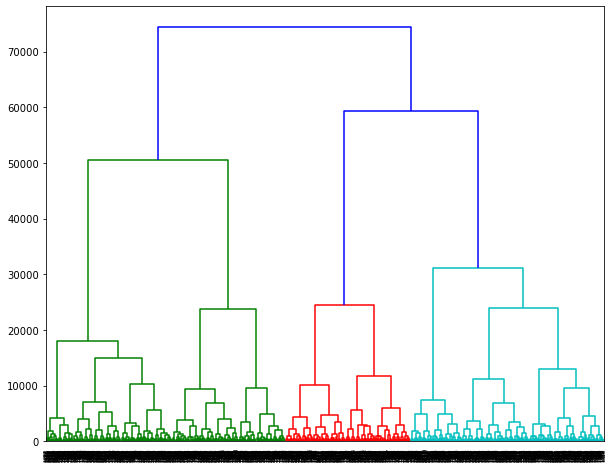

In [11]:
fig= plt.figure(figsize=(10,8))
dend = shc.dendrogram(shc.linkage(X, method='ward'));

In [12]:
for k2 in range(N//SNperCluster+1, Max_it):
    cluster = AgglomerativeClustering(n_clusters=k2, affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    total=0
    CAH = np.zeros((k2,2))
    for i in range(k2):
        points = [X[j] for j in range(len(X)) if cluster.labels_[j] == i]
        CAH[i] = np.mean(points, axis=0)
        
    #print(j)
    for i in range(len(X)):
        distance = dist(X[i],  CAH[cluster.labels_[i]],0)
        if (cluster.labels_==cluster.labels_[i]).sum()>SNperCluster or distance>dth:
            break
        else:
            total+=1
    if (total==len(X)):
        number_Cluster_CAH_init=k2
        break
print("Number of clusters are:",number_Cluster_CAH_init)

Number of clusters are: 68


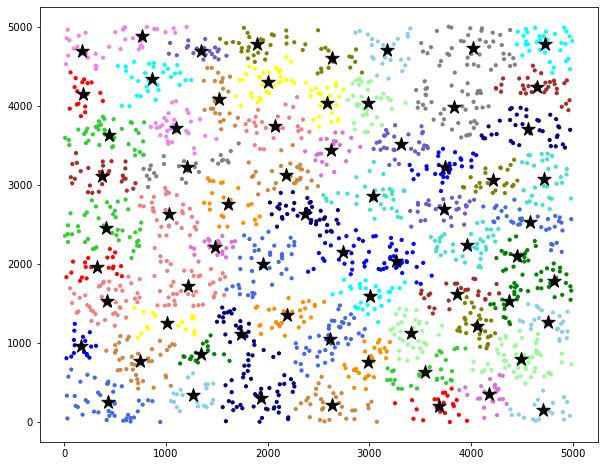

In [13]:
y_CAH = cluster.fit_predict(X)
fig= plt.figure(figsize=(10,8))
plt.scatter(X[:, 0],X[:, 1], s=10,c=y_CAH,cmap=colors)
plt.scatter(CAH[:, 0], CAH[:, 1], marker='*', s=200, c='#050505')

### Proposed Algorithm

In [14]:
def init_Centroids(X,k,dth):
    max_x=int(np.round(np.max(X[:,0])))
    max_y=int(np.round(np.max(X[:,1])))
    C_x=[np.random.randint(dth,max_x-(dth//5))]
    C_y=[np.random.randint(dth,max_y-(dth//5))]
    C=np.array(list(zip(C_x, C_y)), dtype=np.float32)
    while len(C)<k:
        add_C=True
        Aux_x = np.random.randint(dth//8,max_x-(dth//5))
        Aux_y = np.random.randint(0,max_y)
        Aux_C=[Aux_x, Aux_y]
        for i in C:
            if dist(i,Aux_C,0)<500:
                add_C=False
                break
        if add_C:
            C=np.append(C,[Aux_C],0)
    return C

In [72]:
def Proposed_Clustering(dth,X,maxIteration,SNs,N): 
    min_k=int((geo_area**2)//(np.pi*(dth**2)))
    K = range(min_k,maxIteration)
    for k in K:
        C=init_Centroids(X,k,dth)
        # To store the value of centroids when it updates
        C_old = np.zeros(C.shape)
        # Cluster Lables(0, 1, 2)
        clusters = np.ones(len(X))*-1
        # Error func. - Distance between new centroids and old centroids
        error = dist2DPaired(C, C_old)
        max_it=120
        it=0

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0 :
            # Assigning each value to its closest cluster
            #print(it)
            for i in range(len(X)):
                distances = dist(X[i], C)
                cluster = np.argmin(distances)
                S=np.sum(clusters==cluster)
                if it<19:
                    clusters[i] = cluster
                elif S<SNs and distances[cluster]<=dth:
                    clusters[i] = cluster
                else:
                    clusters[i] = k
                    
                #clusters[i] = cluster if (distances[cluster]<=dth and S<SNs) else k
            # Storing the old centroid values
            C_old=deepcopy(C)

            # Finding the new centroids by taking the average value
            for i in range(k):
                C[i] = np.mean(X[clusters==i], axis=0)
            error = dist2DPaired(C, C_old)
            it+=1
            #if error< and np.sum(clusters==k)>SNs//5 :
            #    break
            if it>max_it:
                break
        if np.sum(clusters==k) == 0 :
            break
    
    return k,clusters,C

In [73]:
C1=Proposed_Clustering(dth,X,Max_it,SNperCluster,N);
print("Number of clusters are:",C1[0])

Number of clusters are: 41


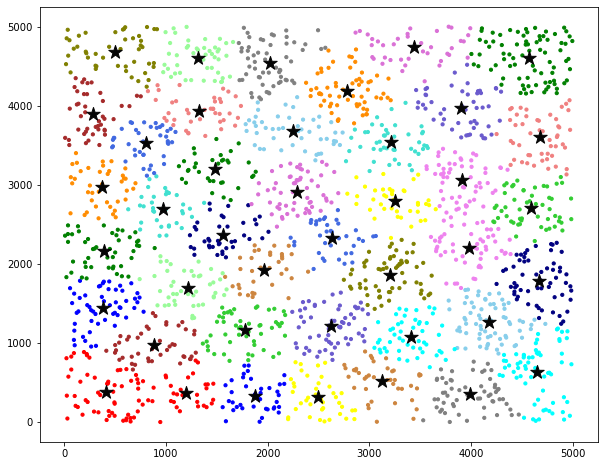

In [76]:
fig= plt.figure(figsize=(10,8))
plt.scatter(X[:, 0],X[:, 1], s=10,c=C1[1],cmap=colors)
plt.scatter(C1[2][:, 0], C1[2][:, 1], marker='*', s=200, c='#050505')

### Comparing algorithms

In [20]:
Clust_Kmeans=[]
for sim in range(100):
    number_Cluster_Kmeans=0
    for j in range(N//SNperCluster+1, Max_it):
        kmeans_init = KMeans(n_clusters=j, max_iter=100)
        kmeans_init.fit(X)
        total=0
        for i in range(len(X)):
            distance = dist(X[i], kmeans_init.cluster_centers_[kmeans_init.labels_[i]],0)
            if (kmeans_init.labels_==kmeans_init.labels_[i]).sum()>SNperCluster or  distance>dth:
                break
            else:
                total+=1
        if (total==len(X)):
            number_Cluster_Kmeans=j
            break
    Clust_Kmeans.append(number_Cluster_Kmeans)

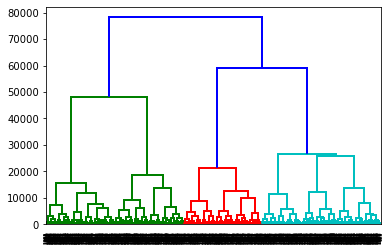

In [21]:
Clust_CAH=[]
for sim in range(100):
    number_Cluster_CAH=0
    dend = shc.dendrogram(shc.linkage(X, method='ward'));
    for k2 in range(N//SNperCluster+1, Max_it):
        cluster = AgglomerativeClustering(n_clusters=k2, affinity='euclidean', linkage='ward')
        cluster.fit_predict(X)
        total=0
        CAH = np.zeros((k2,2))
        for i in range(k2):
            points = [X[j] for j in range(len(X)) if cluster.labels_[j] == i]
            CAH[i] = np.mean(points, axis=0)

        #print(j)
        for i in range(len(X)):
            distance = dist(X[i],  CAH[cluster.labels_[i]],0)
            if (cluster.labels_==cluster.labels_[i]).sum()>SNperCluster or distance>dth:
                break
            else:
                total+=1
        if (total==len(X)):
            number_Cluster_CAH=k2
            break
    Clust_CAH.append(number_Cluster_CAH)

In [22]:
Clust_Proposed=[]
for sim in range(100):
    C1=Proposed_Clustering(dth,X,Max_it,SNperCluster,N);
    Clust_Proposed.append(C1[0])

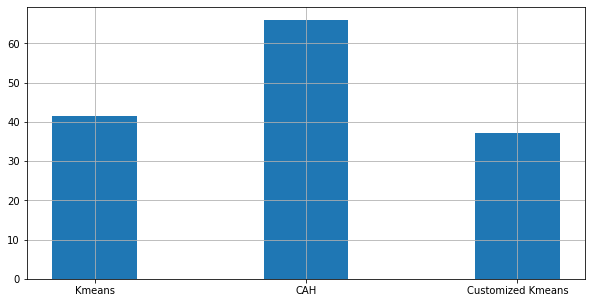

In [23]:
labels=['Kmeans', 'CAH', 'Customized Kmeans']
means=[np.mean(Clust_Kmeans),np.mean(Clust_CAH),np.mean(Clust_Proposed)]
x = np.arange(len(labels))  # the label locations

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, means, width = 0.4)
plt.grid()
plt.show()


In [18]:
df1 = pd.read_csv('data/C1.csv')
df2 = pd.read_csv('data/KM.csv')
df3 = pd.read_csv('data/CAH.csv')

In [19]:
final_C1=df1.values.tolist()
final_KM=df2.values.tolist()
final_CAH=df3.values.tolist()

In [20]:
means_KM=[]
means_CAH=[]
means_C1=[]
for i in range(len(final_C1)):
    means_KM.append(np.mean(final_KM[i]))
    means_CAH.append(np.mean(final_CAH[i]))
    means_C1.append(np.mean(final_C1[i]))

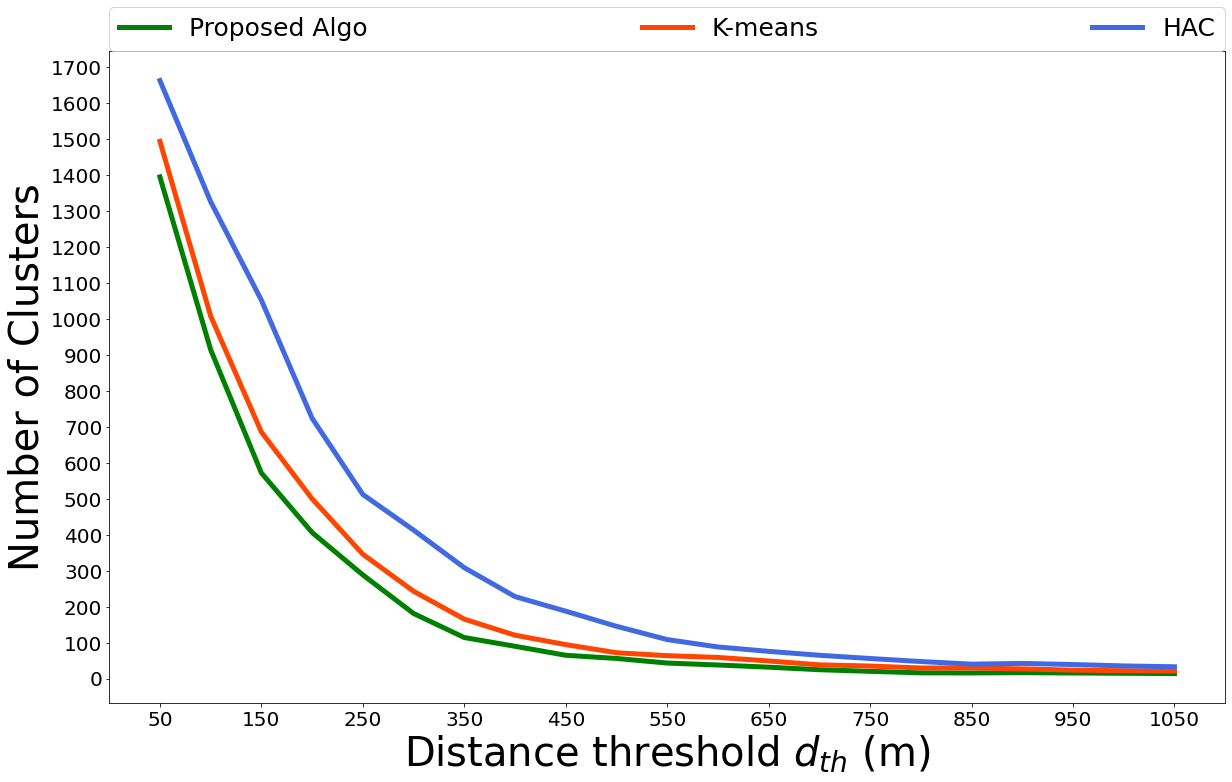

In [21]:
plt.figure(figsize=(20,12))


plt.plot(range(50,1060,50),means_C1,'green',label="Proposed Algo",linewidth=5, markersize=23)
plt.plot(range(50,1060,50),means_KM,'orangered',label="K-means",linewidth=5, markersize=23)
plt.plot(range(50,1060,50),means_CAH,'royalblue',label="HAC",linewidth=5, markersize=23)
plt.xlabel("Distance threshold $d_{th}$ (m)",fontsize=40)
plt.ylabel("Number of Clusters",fontsize=40);
plt.yticks(np.arange(0,1701,100),fontsize=20)
plt.xticks(np.arange(50,1060,100),fontsize=20)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',ncol=3, mode="expand", borderaxespad=0.,prop={'size': 25})

### Further optimization

In [22]:
DS = [2500,2500]

In [23]:
finale=[]
finale.append(DS)
for c in range(C1[0]):
    distance=[]
    for i in range(len(X)):
        if (C1[1][i]==c):
            distance.append(dist(X[i], C1[2][c],0))
    test=deepcopy(C1[2][c])
    while(max(distance)<dth-2 and dist(test,DS,0)>50):
        if test[0]>=DS[0]:
            test[0]=test[0]-np.sqrt(((dth)-max(distance)))
        elif test[0]<DS[0]:
            test[0]=test[0]+np.sqrt(((dth)-max(distance)))
        if test[1]>=DS[1]:
            test[1]=test[1]-np.sqrt(((dth)-max(distance)))
        elif test[1]<DS[1]:
            test[1]=test[1]+np.sqrt(((dth)-max(distance))) 
        distance=[]
        for i in range(len(X)):
            if (C1[1][i]==c):
                distance.append(dist(X[i],test,0))
    finale.append([test[0],test[1]])

In [24]:
CH=np.asarray(finale)
CH_old=np.asarray(C1[2])
CH_Old=np.insert(CH_old,0,DS,axis = 0)

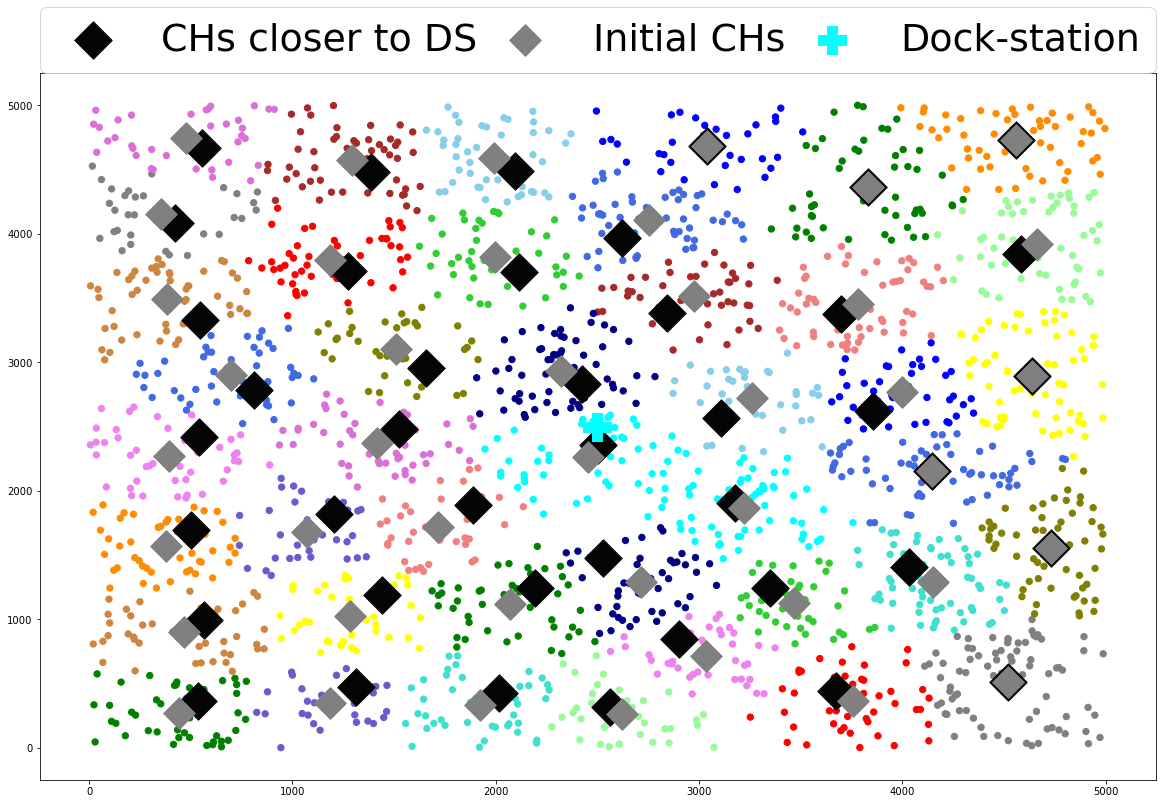

In [25]:
fig= plt.figure(figsize=(20,13))
plt.scatter(X[:, 0],X[:, 1], s=40,c=C1[1],cmap=colors)
plt.scatter(CH[1:, 0], CH[1:, 1], marker='D', s=700, c='#050505',label='CHs closer to DS')
plt.scatter(CH_Old[1:, 0], CH_Old[1:, 1], marker='D', s=500, c='grey',label='Initial CHs')
plt.scatter(DS[0], DS[1], marker='P', s=800, c='cyan',label="Dock-station")
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 38})

### Animated Example

![SegmentLocal](CHs-gif.gif "segment")


# Oﬄine path planning 

###  Simulation parameters

In [26]:
#Time slot in s
delta=0.01 # s
#Average speed in m/s
v_u=30 # m/s
# Noise power
sigma_squared = -109 #-95.98 #dBm
# Pathloss exponent
alpha=1
alpha_NLoS=20
#carrier frequency
f_c=2e9 #Hz
c=3e8 #m/s
power_c= 15 #dBm
# Urban env parameters
C=9.61
B=0.16
#Power Threshold
P_th=-70 #dBm [-100 , -70]
# UAV's altitude
H=100 #m
# Transmission rate
Band_width=10e6 #HZ
# Size of one packet
Sp = 8 * 2**10  # 8192 bit = 1 KB
#blade profile power
Cb = 3.4 #W
#induced power
Ci = 118 #W
#the tip speed of the rotor blade
U_tip = 60 #m/s
#the mean rotor induced velocit
v_0 = 5.4 #m/s
#the air density
psi = 1.225 #Kg/m^3
#the fuselage drag ratio
d_0 = 0.3
#the rotor solidity
r = 0.03
#the rotor disc area
A = 0.28 #m^2
DS = [2500,2500]

### System Model

![SegmentLocal](SM.jpg "segment")

\begin{equation}
    \theta_{cu}=\frac{180}{\pi} \times \arcsin \left(\frac{H}{d_{cu}}\right)
\end{equation}


In [9]:
def Theta(i,u):
    return (180/np.pi) * math.asin(H/dist(i,u,0))

\begin{equation}
\label{eq:prob_path_loss}
    Pr_{cu}^{\rm{LoS}}={1}/{\left(1+a e^{-b \ \left(\theta_{cu}-a\right)}\right)},\; \forall c \in \mathcal{K}_u, \; \forall u \in \mathcal{U}
\end{equation}


In [10]:
def Pr_LoS(i,u):
    return 1/(1+(C*math.exp(-B *(Theta(i,u) - C))))

\begin{equation}
%\small
\label{eq:path_loss}
    l_{cu}^{\rm{LoS}}=20 \log(4\pi f_c / V)+20 \log(d_{iu})+\alpha_{\rm{LoS}}
\end{equation}

In [11]:
def l_LoS(i,u):
    return (20*math.log10((4*np.pi*f_c)/c))+(20*math.log10(dist(i,u,0)))+alpha

\begin{equation}
%\small
\label{eq:path_loss}
    l_{cu}^{\rm{NLoS}}=20 \log(4\pi f_c / V)+20 \log(d_{iu})+\alpha_{\rm{NLoS}}
\end{equation}

In [12]:
def l_NLoS(i,u):
    return (20*math.log10((4*np.pi*f_c)/c))+(20*math.log10(dist(i,u,0)))+alpha_NLoS

\begin{equation}
\label{eq:path_loss}
    \Lambda_{cu}=
     \begin{cases}
    20 \log(4\pi f_c / V)+20 \log(d_{cu})+\eta_{\rm{LoS}}, & \text{ LoS link },\\
    20 \log(4\pi f_c / V)+20 \log(d_{cu})+\eta_{\rm{NLoS}},  & \text{ NLoS link },\\
  \end{cases}
\end{equation}

In [13]:
def Lambda(i,u,Buildings):
    NLoS=False
    for b in Buildings:
        if dist(i[:2],b[:2],0) <= dist(i[:2],u[:2],0) :
            if ((u[0] - i[0])*(b[1] - i[1])) * ((b[0] - i[0])*(u[1] - i[1])) > 0:
                if((b[2]/(dist(i[:2],u[:2],0)-dist(i[:2],b[:2],0)))>(H/dist(i[:2],u[:2],0))):
                    NLoS = True
                    break
    if NLoS:
        #print('********************')
        return l_NLoS(i,u)
    else:
        return l_LoS(i,u)

\begin{equation}
%\small
\label{eq:power_uav_ch}
    P_{cu}=P_{\rm CH}-\Lambda_{cu} %\geq P_{\rm th}
    ,\; \forall c  \in \mathcal{K}_u,\; \forall u   \in \mathcal{U}
\end{equation}

In [14]:
def power(i,u,Buildings):
    return power_c-Lambda(i,u,Buildings)

\begin{equation}
\gamma_{cu}=10^{\frac{P_{cu}-\sigma^2}{10}}
\end{equation}

In [15]:
def gamma(i,u,Buildings):
    return 10**((power(i,u,Buildings)-sigma_squared)/10)

\begin{equation}
%\small
\label{eq:transmission_rate}
    R_{cu}= W \log_2(1+\gamma_{cu}), \; \forall c \in \mathcal{K}_u, \; \forall u \in \mathcal{U}
\end{equation}

In [16]:
def R(i,u,Buildings):
    return Band_width*math.log2(1+gamma(i,u,Buildings))

\begin{equation}
%\small
\label{eq:transmission_time_4_1packet}
T_{1,cu}= \frac{S_{p}}{R_{cu}\delta}, \; \forall c \in \mathcal{K}_u, \; \forall u \in \mathcal{U}
\end{equation}

In [17]:
# Time to transmit one packet in number of Time slots 
def Tp(i,u,Buildings):
    return Sp/(R(i,u,Buildings)*delta)

\begin{equation}
%\small
\label{eq:collectionTime1UAV}
    T_{cu}={Q_c}{T_{1,cu}},\; \forall c \in \mathcal{K}_u, \; \forall u \in \mathcal{U}
\end{equation}

In [18]:
#Data collection time in number of Time slots 
def CollectionTime(Qi,i,u,Buildings):
    return Qi*Tp(i,u,Buildings)

\begin{equation}
%\small
\label{eq:flightTime}
T_{f,u}(i,i')=\frac{||\mathbf{q}_{u,i'}-\mathbf{q}_{u,i}||}{v_u\; \delta}
\end{equation}

In [19]:
#Flying time in number of Time slots 
def FlyingTime(i,j):
    return dist(i,j,0)/(v_u*delta)

\begin{equation}
%\small
\label{eq:propulsion_power}
\begin{split}
P_{\rm{prop},u}(v_u) = \zeta_I \left(\sqrt{1+\frac{v_u^4}{4v_0^4}}-\frac{v_u^2}{2v_0^2}\right)^{1/2}  + \zeta_B \left( 1+\frac{3v_u^2}{U_{\rm tip}^2} \right)  + \frac{1}{2} d_0 \psi r A v_u^3,
\end{split}
\end{equation}

In [20]:
def P_prop(v_u):
    return (Ci * (math.sqrt(1+((v_u**4)/(4*v_0**4))) - ((v_u**2)/(2*v_0**2)) )**(1/2) ) + Cb * (1+((3*v_u**2)/U_tip**2)) + ((1/2)*d_0 * psi * r * A * (v_u**3))

\begin{equation}
%\small
\label{eq:energy}
E_{u}(v,T) = P_{\rm{prop},u}(v) \times T
\end{equation}

In [21]:
def Energy(t,v):
    return P_prop(v) * t

### Importing Data

In [22]:
df_SNs=pd.read_csv('data/SNs.csv')
df_CH_old=pd.read_csv('data/Initial_CHs.csv',index_col=0)
df_CH=pd.read_csv('data/CH_After_algo.csv',index_col=0)
df_Buildings=pd.read_csv('data/buildings.csv',)
CH=np.asarray(df_CH)
CH_Old=np.asarray(df_CH_old)
Buildings=np.asarray(df_Buildings)

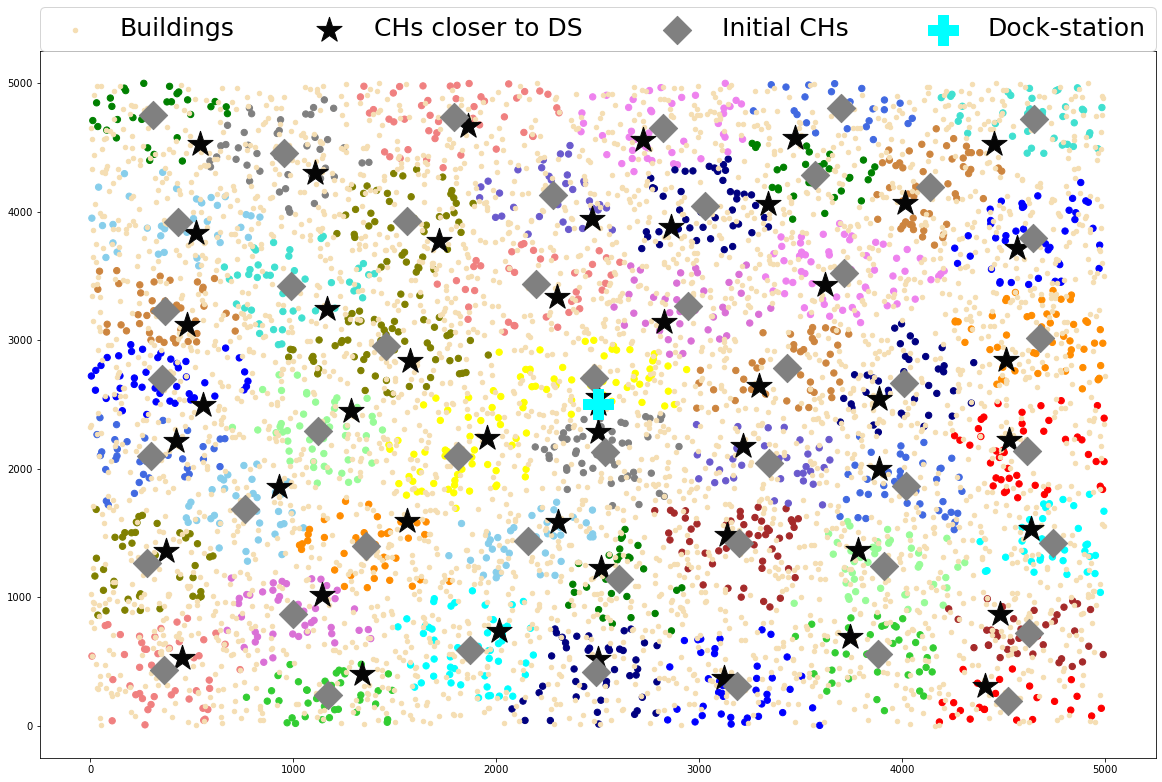

In [23]:
fig= plt.figure(figsize=(20,13))
plt.scatter(df_SNs[:]['X'],df_SNs[:]['Y'], s=40,c=df_SNs[:]['CH'],cmap=colors)
plt.scatter(df_Buildings[:]['X'],df_Buildings[:]['Y'],marker= "o", s=20,c='wheat',label='Buildings')
plt.scatter(df_CH[:]['X'],df_CH[:]['Y'], marker='*', s=700, c='#050505',label='CHs closer to DS')
plt.scatter(df_CH_old[1:]['X'],df_CH_old[1:]['Y'], marker='D', s=400, c='grey',label='Initial CHs')
plt.scatter(DS[0], DS[1], marker='P', s=900, c='cyan',label="Dock-station")
#plt.text(DS[0]+50, DS[1]-100, 'DS',  fontsize=25,c='r')
#plt.annotate(s='', xy=(DS[0], DS[1]), xytext=(kmeans_init.cluster_centers_[15, 0],kmeans_init.cluster_centers_[15, 1]), arrowprops=dict(arrowstyle='<-'))

#for txt in range(kmeans_init.n_clusters):
#    plt.text(kmeans_init.cluster_centers_[txt, 0]-200, kmeans_init.cluster_centers_[txt, 1]+50,txt+1,  fontsize=25)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.,prop={'size': 25})

### Offline Path planning

In [24]:
def create_data_model_with_param(CH,CH_within_range,nbre_packets,deadline,battery_cap,Buildings):
    """Stores the data for the problem."""
    data = {}
    data['time_matrix']=[]
    for i in range(len(CH_within_range)):
        a=[]
        for j in range(len(CH_within_range)):
            a.append(FlyingTime(CH_within_range[j],CH_within_range[i]))
        data['time_matrix'].append(a)

    data['time_windows']=[(0,0)]
    data['uav_collection_time'] = [0]
    for i in range(len(CH_within_range)-1):
        Tc=int(CollectionTime(nbre_packets,np.asarray([CH[i][0],CH[i][1],0]),np.asarray([CH_within_range[i][0],CH_within_range[i][1],H]),Buildings))
        #print(Tc)
        data['uav_collection_time'].append(Tc)
        data['time_windows'].append((0,int(deadline/delta)))

    data['num_uavs'] = len(CH_within_range)-1
    data['uav_capacities']=[]
    # UAV battery capacities
    for i in range(data['num_uavs']):
        data['uav_capacities'].append(int((battery_cap*3.7)/(delta*36))) #3.7 V to convert mAh to W
    data['dock_station'] = 0
    
    return data

In [25]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
      # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = []
    result={}
    for uav_id in range(data['num_uavs']):
        index = routing.Start(uav_id)
        result[uav_id]=[]
        plan_output = 'Route for UAV {}:\n'.format(uav_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            result[uav_id].append((manager.IndexToNode(index),solution.Min(time_var)))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        if solution.Min(time_var) !=0 :
            result[uav_id].append((manager.IndexToNode(index),solution.Min(time_var)))
            plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                        solution.Min(time_var),
                                                        solution.Max(time_var))
            plan_output += 'Time of the route: {0} Time slots | {1:.2f} mins \n'.format(
                solution.Min(time_var),(solution.Min(time_var)*delta)/60)
            print(plan_output)
            total_time.append(solution.Min(time_var))
    print('Total number of UAVs: {}'.format(len(total_time)))
    print('Total time of all routes: {0} Time slots | {1:.2f} mins'.format(max(total_time),(max(total_time)*delta)/60))
    result['MissionTime']=max(total_time)
    result['TotalTime']=sum(total_time)
    return result

In [26]:
def List_solution(data, manager, routing, solution):
    """Prints solution on console."""
    Routes={}
    for uav_id in range(data['num_uavs']):
        Routes[uav_id]=[]
        index = routing.Start(uav_id)
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            Routes[uav_id].append(manager.IndexToNode(index))

    return Routes

In [27]:
def main(data):
    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    #print(data)
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_uavs'], data['dock_station'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    #routing.

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the mission time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['uav_collection_time'][to_node]+data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    time = 'Time'
    routing.AddDimensionWithVehicleCapacity(
        transit_callback_index,
        0,  # allow waiting time
        data['uav_capacities'],
        #1800000, #30 minutes
        #int(max(data['uav_collection_time'])+2*max(data['time_matrix'][0]))+100,  # maximum time per uav
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except dock_station.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each uav start node
    for uav_id in range(data['num_uavs']):
        index = routing.Start(uav_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
        
        
    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_uavs']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))
        
    # Allow to drop nodes.
    for node in range(1, len(data['time_matrix'])):
        #routing.AddDisjunction([manager.NodeToIndex(node)],int((2*data['time_matrix'][0][node])+(data['uav_collection_time'][node])))
        routing.AddDisjunction([manager.NodeToIndex(node)],data['time_windows'][node][1])

    # Setting metaheuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
    search_parameters.time_limit.seconds = 13

    search_parameters.log_search = True
    
    #check the best algo in a limited time (conv time comparaison)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print("Solver status: ", routing.status())
        return List_solution(data, manager, routing, solution),print_solution(data, manager, routing, solution)
    else:
        print('No solution found !')

In [28]:
nbre_packets=5e4
deadline=140
battery_cap=3500

In [84]:
data = create_data_model_with_param(CH,CH,nbre_packets,deadline,battery_cap,Buildings)

In [153]:
data_old = create_data_model_with_param(CH_Old,CH_Old,nbre_packets,deadline,battery_cap,Buildings)

In [156]:
%%time
L,T=main(data)

Solver status:  1
Dropped nodes:
Route for UAV 36:
0 Time(0,0) -> 26 Time(5983,5983) -> 10 Time(8515,8515) -> 45 Time(11344,11344) -> 17 Time(13503,13503) -> 0 Time(22057,22057)
Time of the route: 22057 Time slots | 3.68 mins 

Route for UAV 37:
0 Time(0,0) -> 16 Time(4271,4271) -> 36 Time(8255,8255) -> 6 Time(10662,10662) -> 48 Time(13287,13287) -> 0 Time(17531,17531)
Time of the route: 17531 Time slots | 2.92 mins 

Route for UAV 38:
0 Time(0,0) -> 24 Time(467,467) -> 32 Time(5361,5361) -> 14 Time(8792,8792) -> 13 Time(13748,13748) -> 0 Time(16607,16607)
Time of the route: 16607 Time slots | 2.77 mins 

Route for UAV 39:
0 Time(0,0) -> 21 Time(2968,2968) -> 7 Time(5238,5238) -> 19 Time(7841,7841) -> 44 Time(10190,10190) -> 30 Time(12809,12809) -> 0 Time(20622,20622)
Time of the route: 20622 Time slots | 3.44 mins 

Route for UAV 40:
0 Time(0,0) -> 23 Time(2282,2282) -> 18 Time(5079,5079) -> 39 Time(7733,7733) -> 15 Time(10828,10828) -> 42 Time(13877,13877) -> 0 Time(21920,21920)
Time

In [35]:
%%time
L_old,T_old=main(data_old)

Solver status:  1
Dropped nodes:
Route for UAV 34:
0 Time(0,0) -> 25 Time(4916,4916) -> 1 Time(8007,8007) -> 42 Time(11057,11057) -> 27 Time(13473,13473) -> 0 Time(19862,19862)
Time of the route: 19862 Time slots | 3.31 mins 

Route for UAV 36:
0 Time(0,0) -> 14 Time(8106,8106) -> 5 Time(11327,11327) -> 47 Time(13964,13964) -> 0 Time(24440,24440)
Time of the route: 24440 Time slots | 4.07 mins 

Route for UAV 37:
0 Time(0,0) -> 18 Time(5564,5564) -> 39 Time(7963,7963) -> 15 Time(10800,10800) -> 9 Time(13852,13852) -> 0 Time(22596,22596)
Time of the route: 22596 Time slots | 3.77 mins 

Route for UAV 38:
0 Time(0,0) -> 33 Time(3471,3471) -> 2 Time(6076,6076) -> 44 Time(8532,8532) -> 30 Time(11218,11218) -> 17 Time(13865,13865) -> 0 Time(23110,23110)
Time of the route: 23110 Time slots | 3.85 mins 

Route for UAV 39:
0 Time(0,0) -> 23 Time(2933,2933) -> 29 Time(5701,5701) -> 31 Time(8942,8942) -> 6 Time(11362,11362) -> 36 Time(13980,13980) -> 0 Time(21627,21627)
Time of the route: 21627 

([<matplotlib.axis.XTick at 0x22b2367e6a0>,
 <a list of 6 Text major ticklabel objects>)

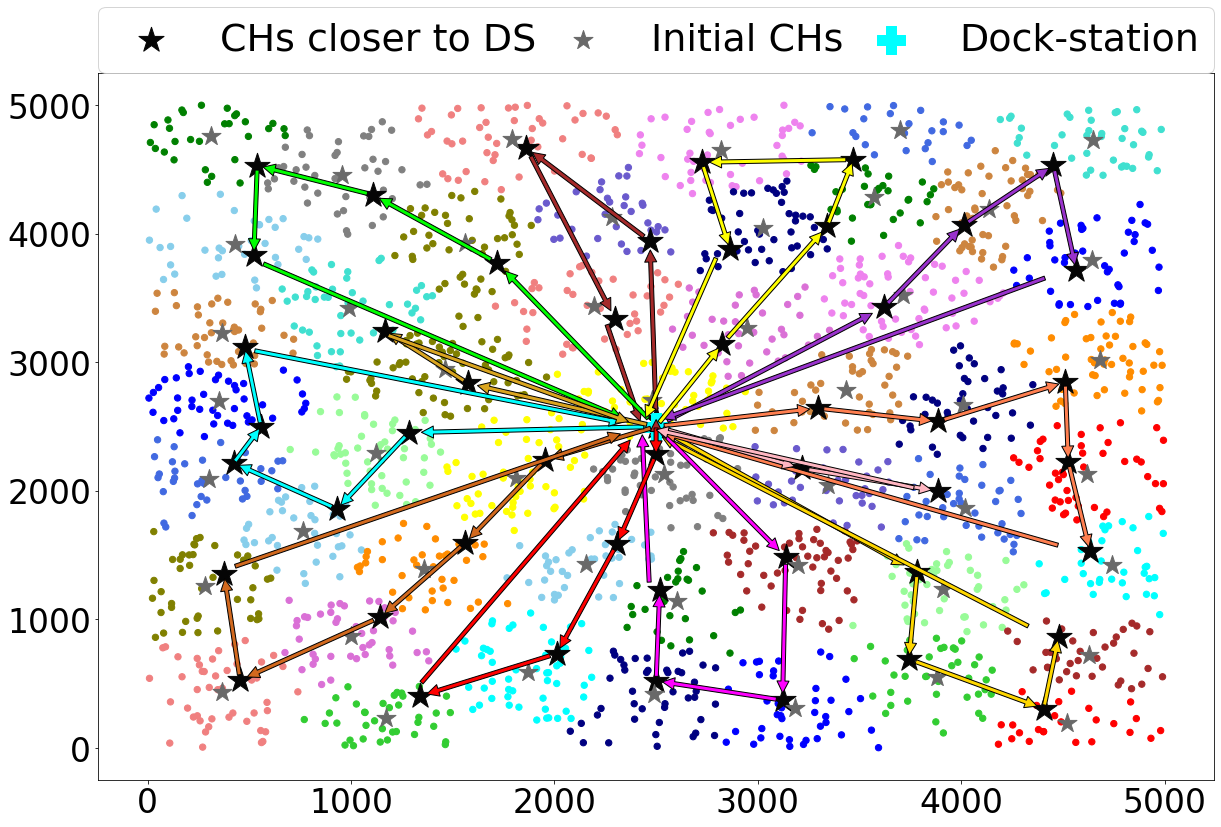

In [36]:
fig= plt.figure(figsize=(20,13))
plt.scatter(df_SNs[:]['X'],df_SNs[:]['Y'], s=40,c=df_SNs[:]['CH'],cmap=colors)
plt.scatter(df_CH[:]['X'],df_CH[:]['Y'], marker='*', s=700, c='#050505',label='CHs closer to DS')
plt.scatter(df_CH_old[:]['X'],df_CH_old[:]['Y'], marker='*', s=400, c='dimgrey',label='Initial CHs')
plt.scatter(DS[0], DS[1], marker='P', s=800, c='cyan',label="Dock-station")
arr_color=['gold','magenta','brown','coral','chocolate','lime','darkorchid','aqua','red','lightpink','yellow','goldenrod','m','blue','aqua','red','lightpink','yellow','goldenrod','m']
cc=0
for i in L:
    if len(L[i])>1 :
      plt.annotate(s='', xy=(CH[L[i][0], 0],CH[L[i][0], 1]), xytext=(DS[0], DS[1]), arrowprops=dict( facecolor=arr_color[cc], shrink=0.05),)
      if (len(L[i])-2>0):
          for j in range(len(L[i])-2):
              plt.annotate(s='', xy=(CH[L[i][j+1], 0],CH[L[i][j+1], 1]), xytext=(CH[L[i][j], 0],CH[L[i][j], 1]), arrowprops=dict(facecolor=arr_color[cc], shrink=0.05),)
      plt.annotate(s='', xy=(DS[0]-70, DS[1]), xytext=(CH[L[i][-2], 0]-50,CH[L[i][-2], 1]), arrowprops=dict(facecolor=arr_color[cc], shrink=0.05),)
      cc+=1
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 38})
#ADD stafey Dist inside and Compare
plt.yticks(np.arange(0,5500,1000),fontsize=33)
plt.xticks(np.arange(0,5500,1000),fontsize=33)

## UAVs hover within a range of CHs

In [30]:
def near_point(P,C,R):
    vX = P[0] - C[0];
    vY = P[1] - C[1];
    magV = np.sqrt(vX*vX + vY*vY);
    aX = C[0] + vX / magV * R;
    aY = C[1] + vY / magV * R;
    return [aX,aY]

In [39]:
CH_new={}
Ranges={}
CH_Final={}
CH_Final[0]=DS
for cchh in range(1,len(CH)):
    for Rn in range(10,1000):
        for i in L:
            CH_new[i]=[]
            if len(L[i])>1 :
                CH_new[i].append(near_point(DS,CH[L[i][0]],Rn))
                if (len(L[i])-2>0):
                    for j in range(len(L[i])-2):
                        CH_new[i].append(near_point(CH[L[i][j]],CH[L[i][j+1]],Rn))
                CH_new[i].append(DS)
        CH_aux=[[]]*(len(CH))
        for i in CH_new:
            if len(CH_new[i])>1 :
                for j in range(len(CH_new[i])):
                    CH_aux[L[i][j]]=CH_new[i][j]
        CH_New=np.asarray(CH_aux)

        if power(np.asarray([CH[cchh][0],CH[cchh][1],0]),np.asarray([CH_New[cchh][0],CH_New[cchh][1],H]),Buildings) <= (power_c-l_NLoS(np.asarray([CH[cchh][0],CH[cchh][1],0]),np.asarray([CH_New[cchh][0],CH_New[cchh][1],H]))):
            final_range=Rn-1
            Ranges[cchh]=final_range
            CH_Final[cchh]=list(CH_New[cchh])
            #print("The optimal range is ",final_range,"meters")
            break
CH_test=[]
for i in CH_Final:
    CH_test.append(CH_Final[i])
CH_range=np.array(CH_test)

In [89]:
for i in L:
    CH_new[i]=[]
    if len(L[i])>1 :
        CH_new[i].append(near_point(DS,CH[L[i][0]],Ranges[i]))
        if (len(L[i])-2>0):
            for j in range(len(L[i])-2):
                CH_new[i].append(near_point(CH[L[i][j]],CH[L[i][j+1]],Ranges[i]))
        CH_new[i].append(DS)
CH_aux=[[]]*(len(CH))
for i in CH_new:
    if len(CH_new[i])>1 :
        for j in range(len(CH_new[i])):
            CH_aux[L[i][j]]=CH_new[i][j]
CH_New=np.asarray(CH_aux)

In [94]:
data_new = create_data_model_with_param(CH,CH_New,nbre_packets,deadline,battery_cap,Buildings)

In [95]:
%%time
L_new,T_new=main(data_new)

Solver status:  1
Dropped nodes:
Route for UAV 35:
0 Time(0,0) -> 43 Time(5106,5106) -> 5 Time(8071,8071) -> 47 Time(10385,10385) -> 28 Time(12791,12791) -> 0 Time(20823,20823)
Time of the route: 20823 Time slots | 3.47 mins 

Route for UAV 36:
0 Time(0,0) -> 26 Time(6014,6014) -> 30 Time(9299,9299) -> 17 Time(12083,12083) -> 45 Time(13985,13985) -> 0 Time(23488,23488)
Time of the route: 23488 Time slots | 3.91 mins 

Route for UAV 37:
0 Time(0,0) -> 23 Time(2134,2134) -> 18 Time(4915,4915) -> 39 Time(7570,7570) -> 15 Time(10665,10665) -> 42 Time(13725,13725) -> 0 Time(21828,21828)
Time of the route: 21828 Time slots | 3.64 mins 

Route for UAV 38:
0 Time(0,0) -> 4 Time(844,844) -> 29 Time(3541,3541) -> 48 Time(5544,5544) -> 31 Time(7872,7872) -> 9 Time(10606,10606) -> 0 Time(18468,18468)
Time of the route: 18468 Time slots | 3.08 mins 

Route for UAV 39:
0 Time(0,0) -> 24 Time(283,283) -> 32 Time(5182,5182) -> 14 Time(8581,8581) -> 13 Time(13190,13190) -> 0 Time(16238,16238)
Time of t

In [41]:
%%time
L_new,T_new=main(data_new)

Solver status:  1
Dropped nodes:
Route for UAV 35:
0 Time(0,0) -> 25 Time(4501,4501) -> 27 Time(7232,7232) -> 42 Time(10548,10548) -> 15 Time(13472,13472) -> 0 Time(22809,22809)
Time of the route: 22809 Time slots | 3.80 mins 

Route for UAV 36:
0 Time(0,0) -> 21 Time(2737,2737) -> 7 Time(5563,5563) -> 33 Time(8578,8578) -> 16 Time(11277,11277) -> 0 Time(15092,15092)
Time of the route: 15092 Time slots | 2.52 mins 

Route for UAV 37:
0 Time(0,0) -> 43 Time(5355,5355) -> 5 Time(8495,8495) -> 47 Time(11057,11057) -> 28 Time(13564,13564) -> 0 Time(21646,21646)
Time of the route: 21646 Time slots | 3.61 mins 

Route for UAV 38:
0 Time(0,0) -> 26 Time(6083,6083) -> 10 Time(8815,8815) -> 45 Time(11772,11772) -> 17 Time(13823,13823) -> 0 Time(22531,22531)
Time of the route: 22531 Time slots | 3.76 mins 

Route for UAV 39:
0 Time(0,0) -> 13 Time(3637,3637) -> 14 Time(8324,8324) -> 32 Time(11963,11963) -> 0 Time(16496,16496)
Time of the route: 16496 Time slots | 2.75 mins 

Route for UAV 40:
0 

([<matplotlib.axis.XTick at 0x22b272858b0>,
 <a list of 6 Text major ticklabel objects>)

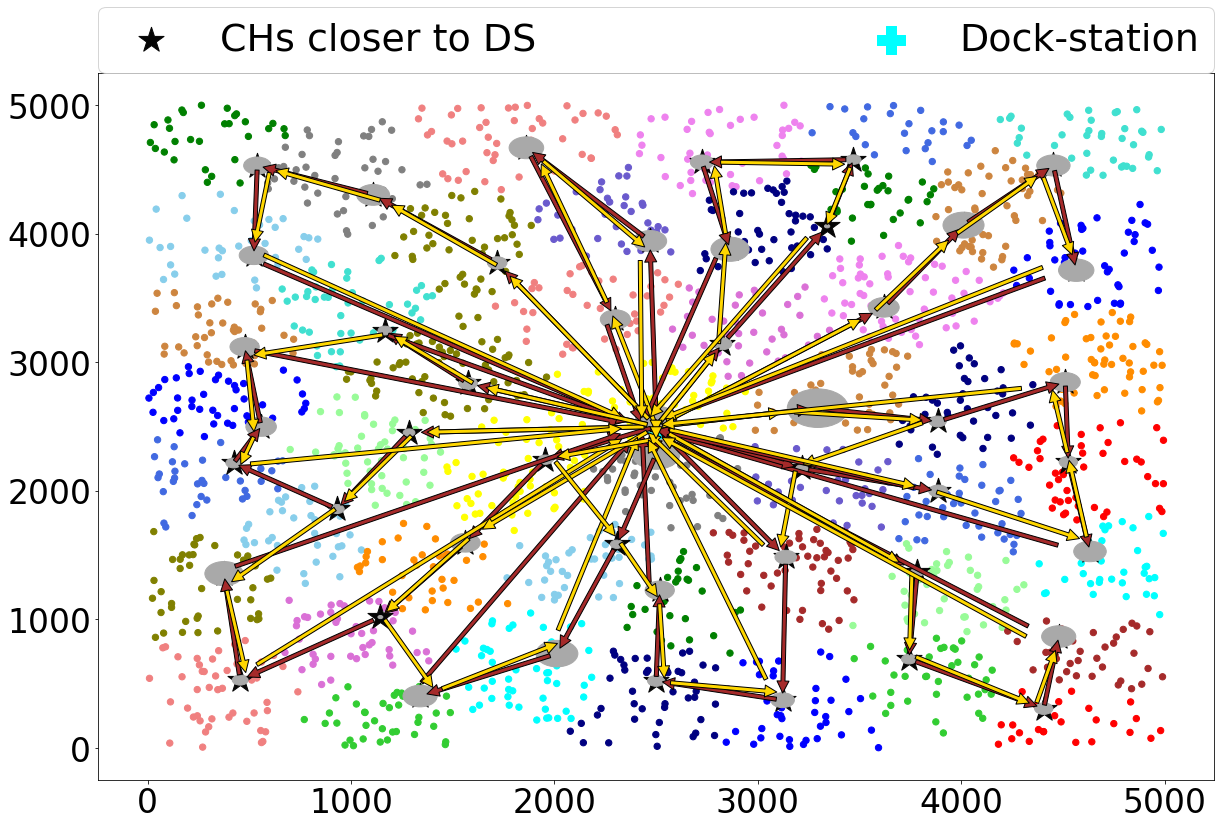

In [81]:
#fig= plt.figure(figsize=(20,13))
fig, ax = plt.subplots(figsize=(20,13))

plt.scatter(df_SNs[:]['X'],df_SNs[:]['Y'], s=40,c=df_SNs[:]['CH'],cmap=colors)

plt.scatter(df_CH[:]['X'],df_CH[:]['Y'], marker='*', s=700, c='#050505',label='CHs closer to DS')
#plt.scatter(df_CH[:]['X'],df_CH[:]['Y'], marker='*', s=700, c='darkgrey',label='Range of CHs')

#plt.scatter(df_CH_old[:]['X'],df_CH_old[:]['Y'], marker='*', s=400, c='dimgrey',label='Initial CHs')
plt.scatter(DS[0], DS[1], marker='P', s=800, c='cyan',label="Dock-station")
#for k in range(len(CH)):
#    ax.add_artist(plt.Circle((CH[k, 0], CH[k, 1]),final_range))
for k in range(1,len(CH)):
    ax.add_artist(plt.Circle((CH[k, 0], CH[k, 1]),Ranges[k],color='darkgrey'))
arr_color=['gold','magenta','brown','coral','chocolate','lime','darkorchid','aqua','red','lightpink','yellow','goldenrod','m','blue','aqua','red','lightpink','yellow','goldenrod','m']
cc=0
for i in L:
    if len(L[i])>1 :
      plt.annotate(s='', xy=(CH[L[i][0], 0],CH[L[i][0], 1]), xytext=(DS[0], DS[1]), arrowprops=dict( facecolor='brown', shrink=0.05),)
      if (len(L[i])-2>0):
          for j in range(len(L[i])-2):
              plt.annotate(s='', xy=(CH[L[i][j+1], 0],CH[L[i][j+1], 1]), xytext=(CH[L[i][j], 0],CH[L[i][j], 1]), arrowprops=dict(facecolor='brown', shrink=0.05),)
      plt.annotate(s='', xy=(DS[0]-70, DS[1]), xytext=(CH[L[i][-2], 0]-50,CH[L[i][-2], 1]), arrowprops=dict(facecolor='brown', shrink=0.05),)
      cc+=1

        
for i in L_new:
    if len(L_new[i])>1 :
      plt.annotate(s='', xy=(CH_range[L_new[i][0], 0],CH_range[L_new[i][0], 1]), xytext=(DS[0], DS[1]), arrowprops=dict( facecolor='gold', shrink=0.05),)
      if (len(L_new[i])-2>0):
          for j in range(len(L_new[i])-2):
              plt.annotate(s='', xy=(CH_range[L_new[i][j+1], 0],CH_range[L_new[i][j+1], 1]), xytext=(CH_range[L_new[i][j], 0],CH_range[L_new[i][j], 1]), arrowprops=dict(facecolor='gold', shrink=0.05),)
      plt.annotate(s='', xy=(DS[0]-70, DS[1]), xytext=(CH_range[L_new[i][-2], 0]-50,CH_range[L_new[i][-2], 1]), arrowprops=dict(facecolor='gold', shrink=0.05),)
#for txt in range(1,len(CH)):
#    plt.text(CH[txt, 0], CH[txt, 1],txt,  fontsize=25)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 38})
#ADD stafey Dist inside and Compare
plt.yticks(np.arange(0,5500,1000),fontsize=33)
plt.xticks(np.arange(0,5500,1000),fontsize=33)

### Comparing performances of Tabu search , Simulated annealing, and Guided local search

In [29]:
def compare_solutions(data, manager, routing, solution):
    """Prints solution on console."""
      # Display dropped nodes.
    dropped_nodes = []
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_nodes.append(manager.IndexToNode(node))
    #print(dropped_nodes)
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = []
    energy=0
    routes={}
    result={}
    for uav_id in range(data['num_uavs']):
        index = routing.Start(uav_id)
        result[uav_id]=[]
        plan_output = 'Route for UAV {}:\n'.format(uav_id)
        routes[uav_id]=[]
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            result[uav_id].append((manager.IndexToNode(index),solution.Min(time_var)))
            routes[uav_id].append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        if solution.Min(time_var) !=0 :
            result[uav_id].append((manager.IndexToNode(index),solution.Min(time_var)))
            plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                        solution.Min(time_var),
                                                        solution.Max(time_var))
            routes[uav_id].append(manager.IndexToNode(index))
            plan_output += 'Time of the route: {0} Time slots | {1:.2f} mins \n'.format(
                solution.Min(time_var),(solution.Min(time_var)*delta)/60)
            #energy.append((data['time_matrix'][solution.Min(time_var)][solution.Max(time_var)]*delta*p_prop)+(data['uav_collection_time'][manager.IndexToNode(index)]*p_hov*delta))
            total_time.append(solution.Min(time_var))

    for i in routes:
      if len(routes[i])>1:
        #print(routes[i])
        for j in range(len(routes[i])-1):
          energy+=((P_prop(v_u)*data['time_matrix'][routes[i][j]][routes[i][j+1]]*delta)+(P_prop(0)*data['uav_collection_time'][routes[i][j+1]]*delta))

    return len(total_time),dropped_nodes,sum(total_time),energy

In [30]:
def compare(data,limit_time,option):
    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    #print(data)
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_uavs'], data['dock_station'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the mission time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['uav_collection_time'][to_node]+data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    time = 'Time'
    routing.AddDimensionWithVehicleCapacity(
        transit_callback_index,
        0,  # allow waiting time
        data['uav_capacities'],
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except dock_station.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each uav start node
    for uav_id in range(data['num_uavs']):
        index = routing.Start(uav_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
        
        
    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_uavs']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))
        
    # Allow to drop nodes.
    for node in range(1, len(data['time_matrix'])):
        #routing.AddDisjunction([manager.NodeToIndex(node)],int((2*data['time_matrix'][0][node])+(data['uav_collection_time'][node])))
        routing.AddDisjunction([manager.NodeToIndex(node)],data['time_windows'][node][1])
            

    # Setting metaheuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (option)
    search_parameters.time_limit.seconds = limit_time
    #search_parameters.log_search = True
    
    #check the best algo in a limited time (conv time comparaison)
    
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        return compare_solutions(data, manager, routing, solution)
    else:
        print('No solution found !')

### Comparing Different Algorithms

In [ ]:
%%time
limit_time=10
performances1={}
performances1['num_UAV']=[]
performances1['visited_CHs']=[]
performances1['energy']=[]

performances2={}
performances2['num_UAV']=[]
performances2['visited_CHs']=[]
performances2['energy']=[]

performances3={}
performances3['num_UAV']=[]
performances3['visited_CHs']=[]
performances3['energy']=[]


for i in range(500,10002,500):
    data_per=create_data_model_with_param(CH,CH,nbre_packets,140,i)
    start_time = time.time()
    num_UAVs1,dropped_CHs1,sumTime1,energy1=compare(data_per,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
    num_UAVs2,dropped_CHs2,sumTime2,energy2=compare(data_per,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
    num_UAVs3,dropped_CHs3,sumTime3,energy3=compare(data_per,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)


    performances1['num_UAV'].append(num_UAVs1)
    performances1['visited_CHs'].append(len(CH)-len(dropped_CHs1))
    performances1['energy'].append(round(energy1/1000,2))


    performances2['num_UAV'].append(num_UAVs2)
    performances2['visited_CHs'].append(len(CH)-len(dropped_CHs2))
    performances2['energy'].append(round(energy2/1000,2))

    performances3['num_UAV'].append(num_UAVs3)
    performances3['visited_CHs'].append(len(CH)-len(dropped_CHs3))
    performances3['energy'].append(round(energy3/1000,2))


    execution_time=(time.time() - start_time)

In [60]:
performances1=pd.read_csv('SIMULATED_ANNEALING_120s_deadline.csv',index_col=0)
performances2=pd.read_csv('TABU_SEARCH_120s_deadline.csv',index_col=0)
performances3=pd.read_csv('GUIDED_LOCAL_SEARCH_120s_deadline.csv',index_col=0)

In [61]:
performances1=pd.read_csv('SIMULATED_ANNEALING_140s_deadline_final.csv',index_col=0)
performances2=pd.read_csv('TABU_SEARCH_140s_deadline_final.csv',index_col=0)
performances3=pd.read_csv('GUIDED_LOCAL_SEARCH_140s_deadline_final.csv',index_col=0)

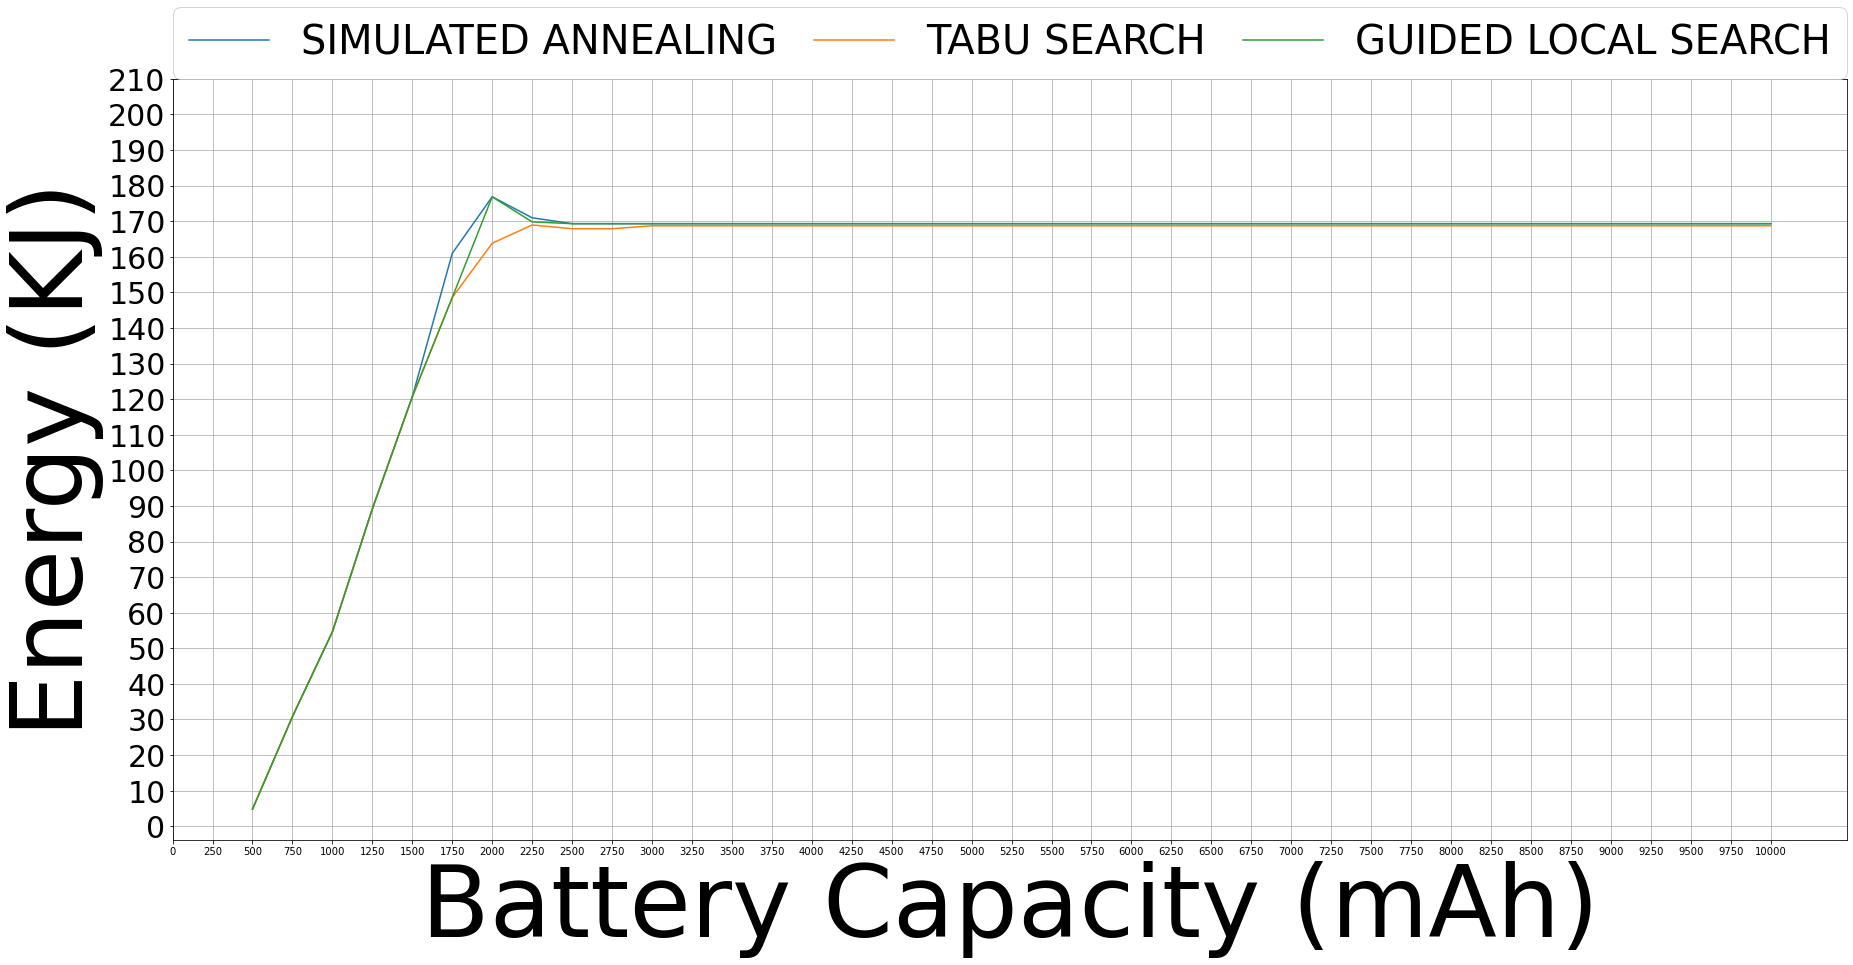

In [62]:
x=np.arange(500,10002,250)
plt.figure(figsize=(30,14))

plt.plot(x, performances1.loc['energy'],label="SIMULATED ANNEALING")
plt.plot(x, performances2.loc['energy'],label="TABU SEARCH")
plt.plot(x, performances3.loc['energy'],label="GUIDED LOCAL SEARCH")
plt.xticks(np.arange(0,10002,250))
plt.yticks(np.arange(0,max(performances1.loc['energy'])+40,10),fontsize=30)
plt.xlabel('Battery Capacity (mAh)',fontsize=100)
plt.ylabel('Energy (KJ)',fontsize=100)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)


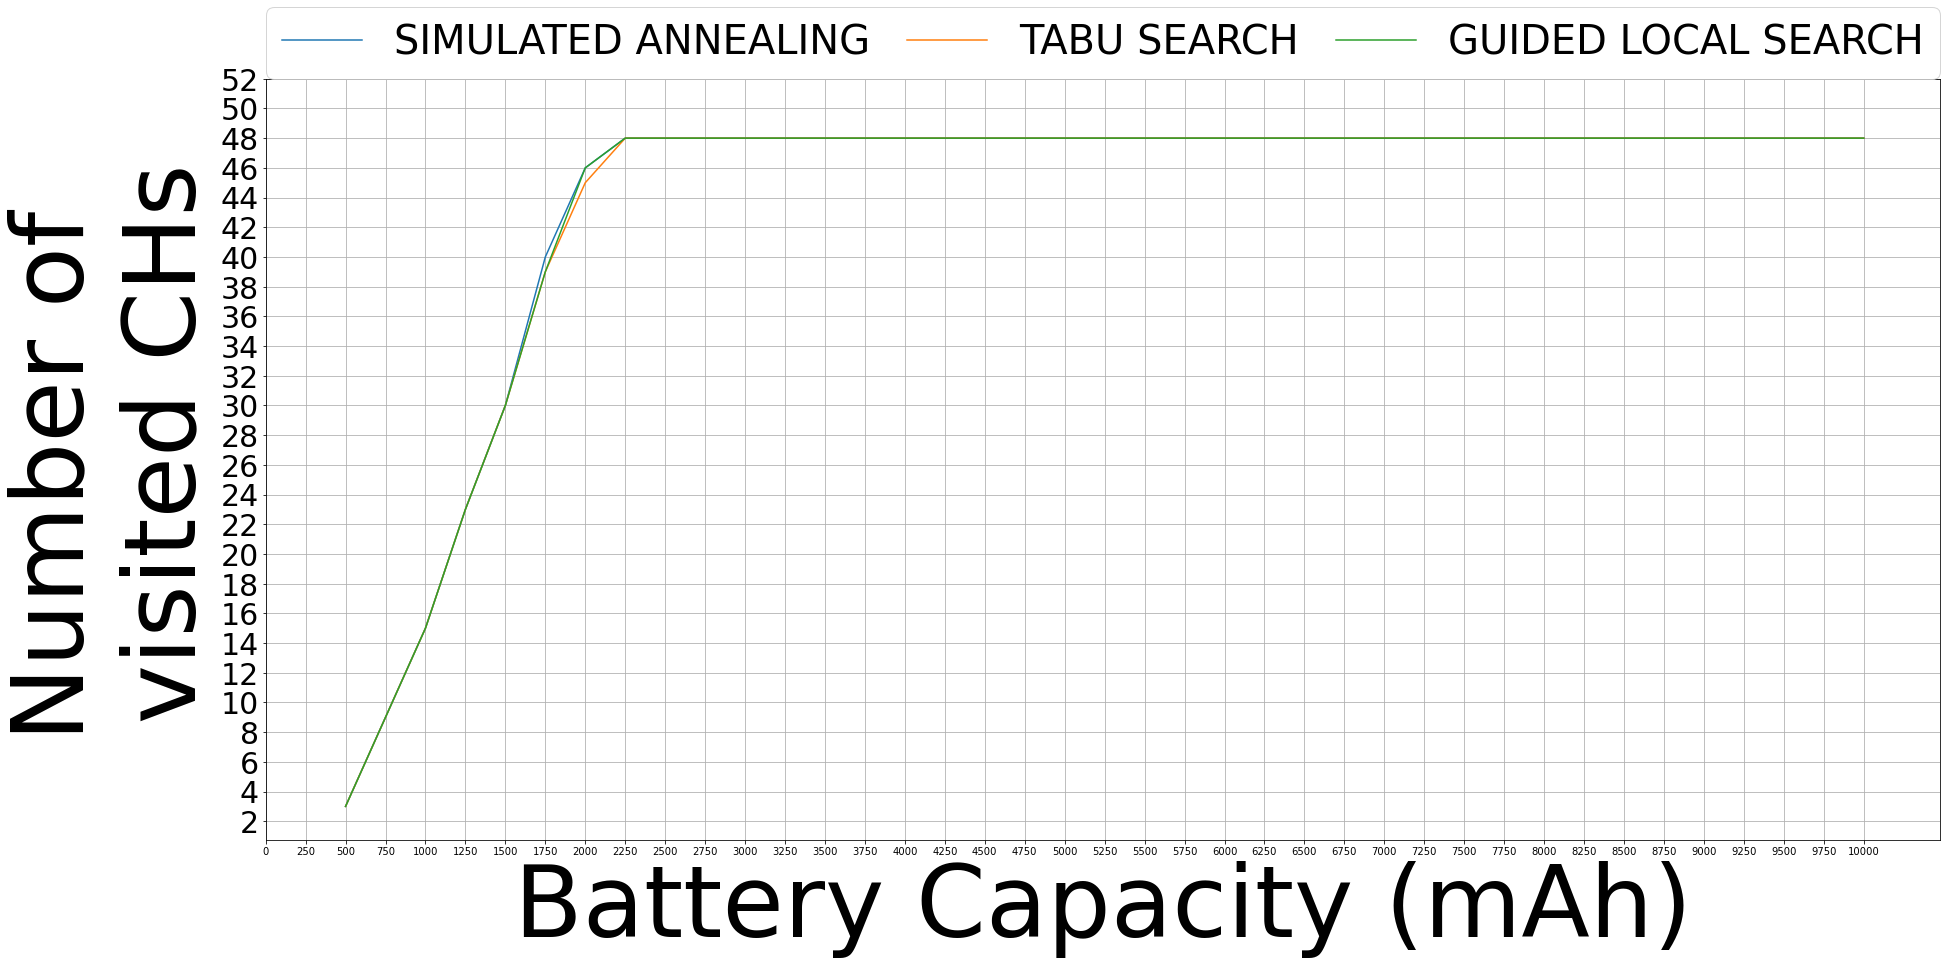

In [63]:
x=np.arange(500,10002,250)
plt.figure(figsize=(30,14))

plt.plot(x, performances1.loc['visited_CHs'],label="SIMULATED ANNEALING")
plt.plot(x, performances2.loc['visited_CHs'],label="TABU SEARCH")
plt.plot(x, performances3.loc['visited_CHs'],label="GUIDED LOCAL SEARCH")
plt.xticks(np.arange(0,10002,250))
plt.yticks(np.arange(min(performances3.loc['visited_CHs'])-1,max(performances3.loc['visited_CHs'])+5,2),fontsize=30)
plt.xlabel('Battery Capacity (mAh)',fontsize=100)
plt.ylabel('Number of \n visited CHs',fontsize=100)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)

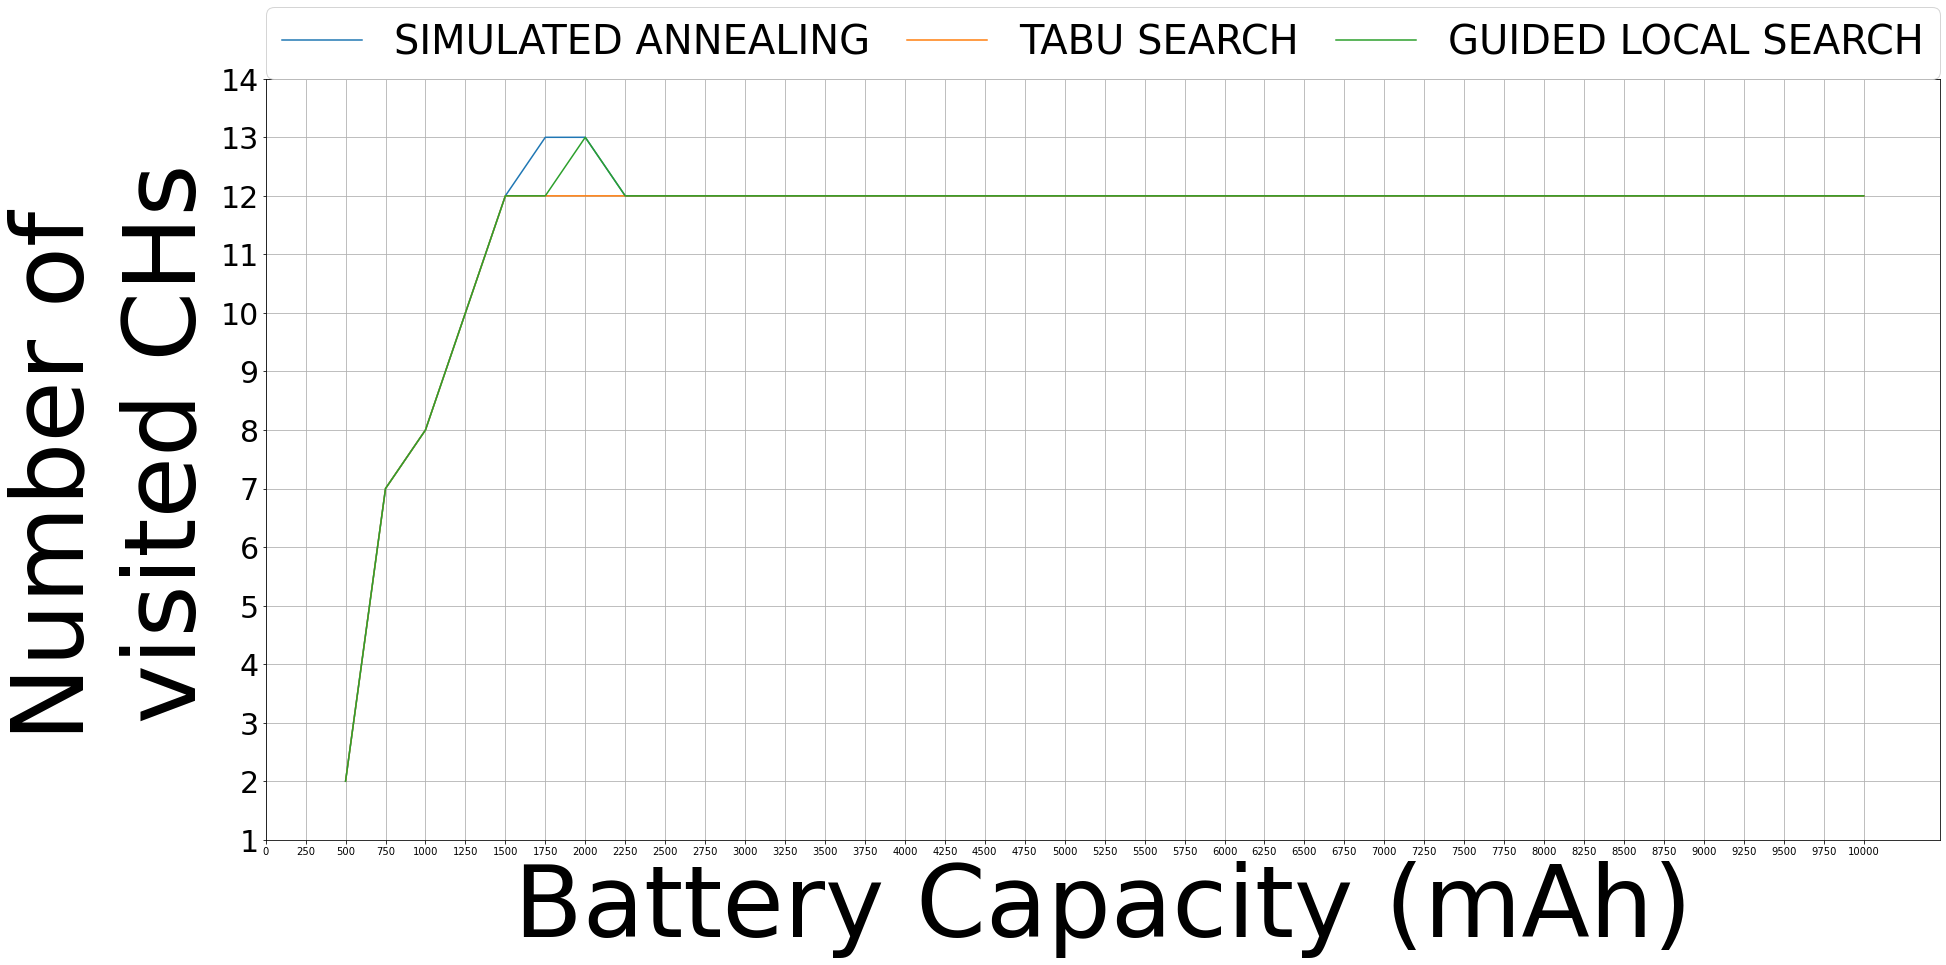

In [64]:
x=np.arange(500,10002,250)
plt.figure(figsize=(30,14))

plt.plot(x, performances1.loc['num_UAV'],label="SIMULATED ANNEALING")
plt.plot(x, performances2.loc['num_UAV'],label="TABU SEARCH")
plt.plot(x, performances3.loc['num_UAV'],label="GUIDED LOCAL SEARCH")
plt.xticks(np.arange(0,10002,250))
plt.yticks(np.arange(min(performances3.loc['num_UAV'])-1,max(performances3.loc['num_UAV'])+2,1),fontsize=30)
plt.xlabel('Battery Capacity (mAh)',fontsize=100)
plt.ylabel('Number of \n visited CHs',fontsize=100)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)

### Comparing data collection's location

In [340]:
%%time
limit_time=10

performances={}
performances['num_UAV']=[]
performances['visited_CHs']=[]
performances['energy']=[]

performances_old={}
performances_old['num_UAV']=[]
performances_old['visited_CHs']=[]
performances_old['energy']=[]

performances_new={}
performances_new['num_UAV']=[]
performances_new['visited_CHs']=[]
performances_new['energy']=[]


for i in range(10,500,100):
    data_per=create_data_model_with_param(CH,CH,nbre_packets,i,battery_cap)
    data_per_old=create_data_model_with_param(CH_Old,CH_Old,nbre_packets,i,battery_cap)
    data_per_new=create_data_model_with_param(CH,CH_New,nbre_packets,i,battery_cap)
  
    num_UAVs,dropped_CHs,sumTime,energy=compare(data_per,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
    num_UAVs_old,dropped_CHs_old,sumTime_old,energy_old=compare(data_per_old,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)
    num_UAVs_new,dropped_CHs_new,sumTime_new,energy_new=compare(data_per_new,limit_time,routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH)

    performances['num_UAV'].append(num_UAVs)
    performances['visited_CHs'].append(len(CH)-1-len(dropped_CHs))
    performances['energy'].append(round(energy/1000,2))

    performances_old['num_UAV'].append(num_UAVs_old)
    performances_old['visited_CHs'].append(len(CH_Old)-1-len(dropped_CHs_old))
    performances_old['energy'].append(round(energy_old/1000,2))

    performances_new['num_UAV'].append(num_UAVs_new)
    performances_new['visited_CHs'].append(len(CH_New)-1-len(dropped_CHs_new))
    performances_new['energy'].append(round(energy_new/1000,2))

Wall time: 1min 39s


In [65]:
performances=pd.read_csv('Closer_CHs_3500mAh_final.csv',index_col=0)
performances_old=pd.read_csv('Initial_CHs_3500mAh_final.csv',index_col=0)
performances_new=pd.read_csv('Within_range_CHs_3500mAh_final.csv',index_col=0)

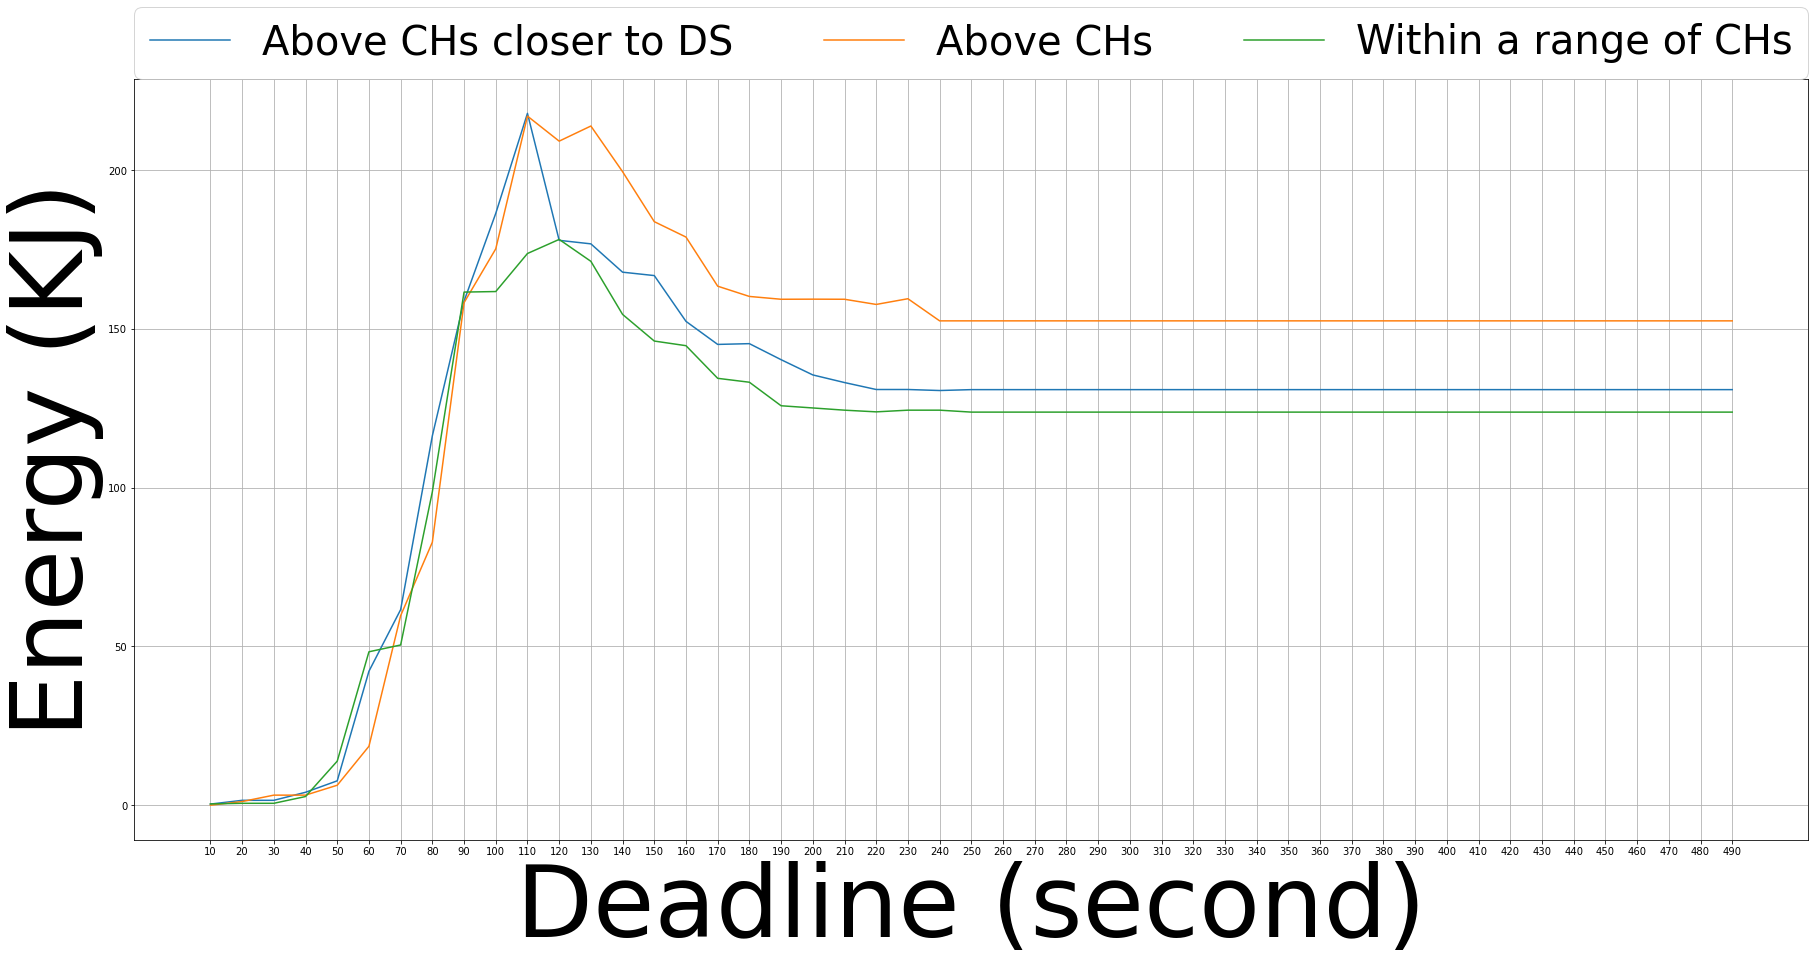

In [66]:
x=np.arange(10,500,10)
plt.figure(figsize=(30,14))

plt.plot(x,performances.loc['energy'],label="Above CHs closer to DS")
plt.plot(x,performances_old.loc['energy'],label="Above CHs")
plt.plot( x,performances_new.loc['energy'],label="Within a range of CHs")
plt.xticks(np.arange(10,500,10))
#plt.yticks(np.arange(0,max(performances_old['energy'])+10,10),fontsize=30)
plt.xlabel('Deadline (second)',fontsize=100)
plt.ylabel('Energy (KJ)',fontsize=100)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)


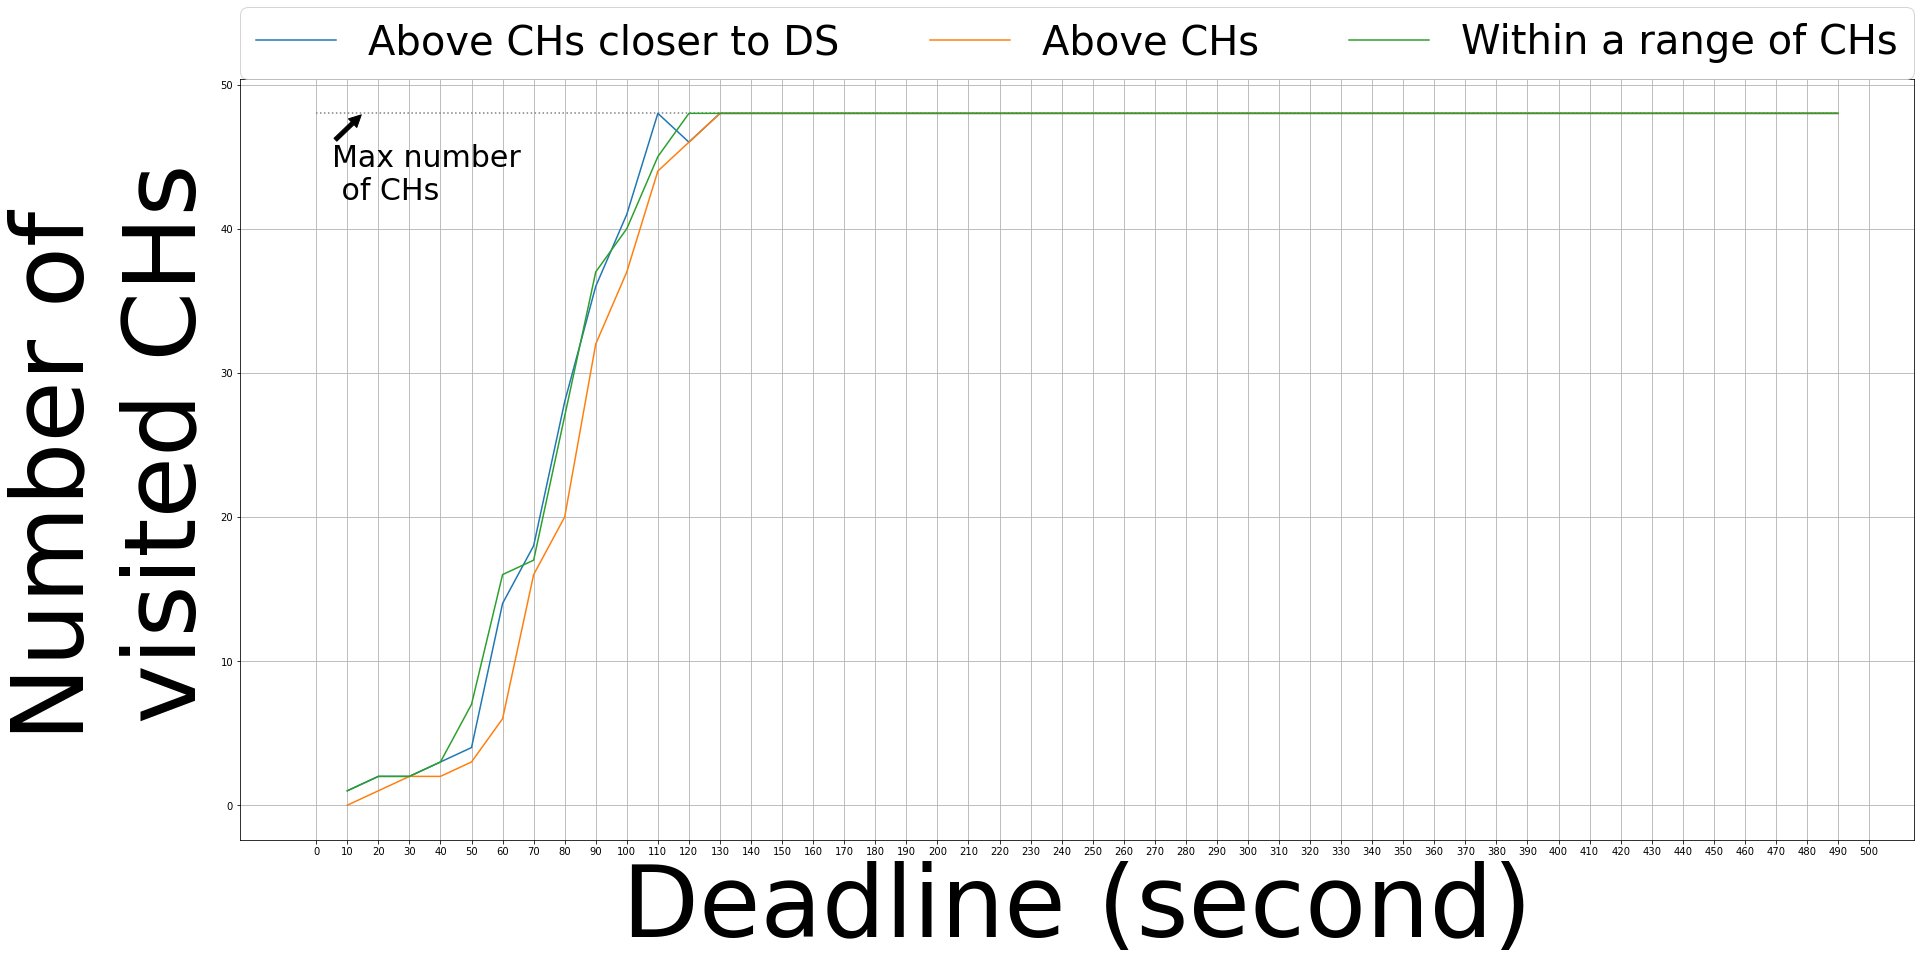

In [67]:
x=np.arange(10,500,10)
fig, ax = plt.subplots(figsize=(30,14))


plt.plot(x, performances.loc['visited_CHs'],label="Above CHs closer to DS")
plt.plot(x, performances_old.loc['visited_CHs'],label="Above CHs")
plt.plot(x, performances_new.loc['visited_CHs'],label="Within a range of CHs")
plt.hlines(y=len(CH)-1, xmin=0, xmax=max(x), linestyle=':', color='grey')
ax.annotate('Max number\n of CHs', xy=(15, len(CH)-1), xytext=(5, len(CH)-7),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=30)
plt.xticks(np.arange(0,510,10))
plt.xlabel('Deadline (second)',fontsize=100)
plt.ylabel('Number of \n visited CHs',fontsize=100)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)

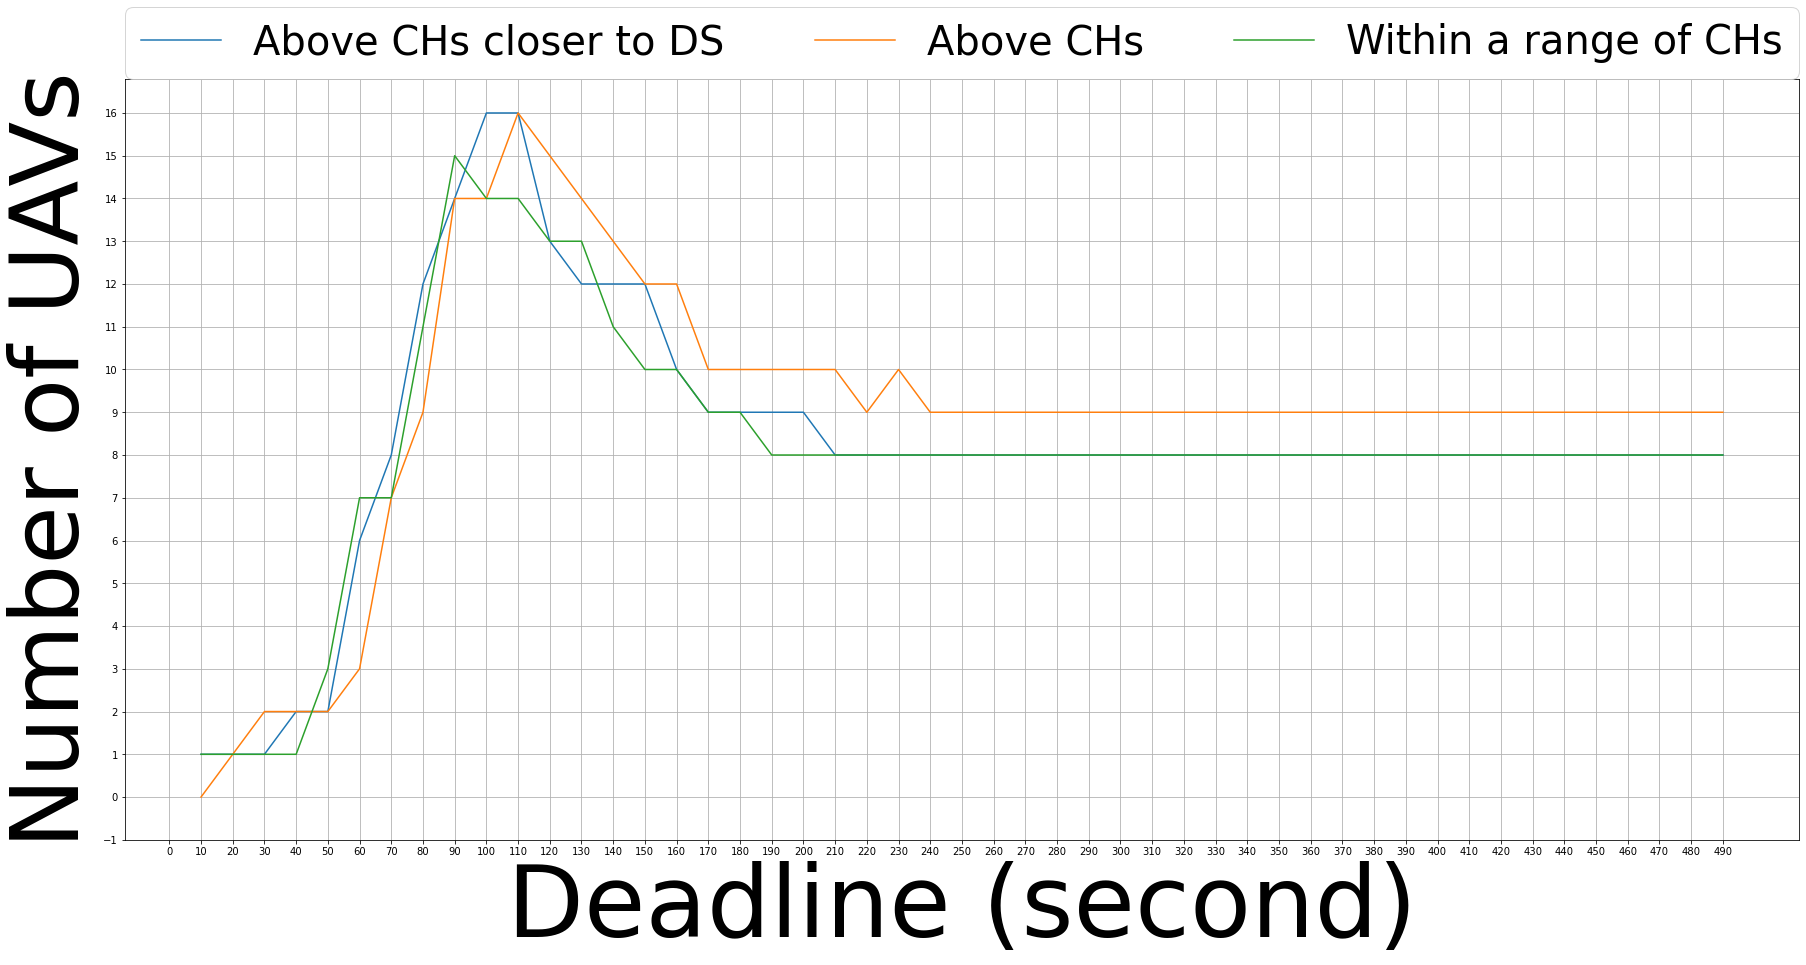

In [68]:
x=np.arange(10,500,10)
plt.figure(figsize=(30,14))

plt.plot(x, performances.loc['num_UAV'],label="Above CHs closer to DS")
plt.plot(x, performances_old.loc['num_UAV'],label="Above CHs")
plt.plot(x, performances_new.loc['num_UAV'],label="Within a range of CHs")
plt.xticks(np.arange(0,500,10))
plt.yticks(np.arange(min(performances_old.loc['num_UAV'])-1,max(performances_old.loc['num_UAV'])+1
                     ,1))
plt.xlabel('Deadline (second)',fontsize=100)
plt.ylabel('Number of UAVs',fontsize=95)
plt.legend(bbox_to_anchor=(0., 1, 1., .1), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.,prop={'size': 40})
plt.grid(True)